In [42]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import pickle as p
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import geopy.distance
import folium
import jenkspy

## Data Cleaning

In [232]:
ods = pd.read_csv("fare scenarios/rail_od_distances.csv", 
                  encoding='windows-1252')

In [233]:
ods

,ORIGIN_MSTN_ID,ORIGIN_NAME,ORIGIN_X_COORD,ORIGIN_Y_COORD,DEST_MSTN_ID,DEST_NAME,DEST_X_COORD,DEST_Y_COORD,TRACK_MILE,COMPOSITE_MILE,CROW_FLIES_MILES_GIS,TRAVEL_TIME,TRACK_MILE_FY18_FINAL,COMP_MILE_FY18_FINAL
0,MSTN_042,ROCKVILLE,-77.146191,39.084264,MSTN_056,NEW CARROLLTON,-76.871868,38.948020,26.58,22.04,17.5009,65.0,26.59,22.04
1,MSTN_014,FEDERAL CENTER SW,-77.015935,38.885068,MSTN_012,FARRAGUT NORTH,-77.039666,38.903139,2.29,2.04,1.7866,14.0,2.29,2.04
2,MSTN_065,ARLINGTON CEMETERY,-77.063097,38.884581,MSTN_061,COURT HOUSE,-77.087141,38.890145,2.03,1.69,1.3499,10.0,2.03,1.69
3,MSTN_038,VAN NESS-UDC,-77.062951,38.943203,MSTN_059,WEST FALLS CHURCH-VT/UVA,-77.189219,38.900781,13.72,10.54,7.4066,38.0,13.71,10.56
4,MSTN_027,NAVY YARD-BALLPARK,-77.005875,38.876465,MSTN_048,FOREST GLEN,-77.042925,39.014938,12.35,11.06,9.7588,34.0,12.24,11.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9404,MSTN_044,GLENMONT,-77.053546,39.061759,MSTN_093,HERNDON,-77.385178,38.952821,36.45,27.91,NaN,NaN,NaN,NaN
9405,MSTN_046,WHEATON,-77.050108,39.037535,MSTN_093,HERNDON,-77.385178,38.952821,34.68,26.82,NaN,NaN,NaN,NaN
9406,MSTN_046,WHEATON,-77.050108,39.037535,MSTN_096,LOUDOUN GATEWAY,-77.460685,38.992040,41.34,31.83,NaN,NaN,NaN,NaN
9407,MSTN_048,FOREST GLEN,-77.042925,39.014938,MSTN_095,DULLES AIRPORT,-77.448148,38.955784,36.88,29.53,NaN,NaN,NaN,NaN


`CROW_FLIES_MILES_GIS` is not available for new/planned stations. Let's calculate a new distance column based on the provided coordinates, using geopy. 

In [234]:
ods['DIST_MI'] = ods.apply(lambda x: geopy.distance.distance((x.ORIGIN_Y_COORD, x.ORIGIN_X_COORD), 
                                                           (x.DEST_Y_COORD, x.DEST_X_COORD)).mi, axis=1)

Let's check to see what the biggest discrepency is:

In [235]:
(ods.DIST_MI - ods.CROW_FLIES_MILES_GIS).max()

0.04846111690472643

In [236]:
ods[ods.DIST_MI - ods.CROW_FLIES_MILES_GIS == (ods.DIST_MI - ods.CROW_FLIES_MILES_GIS).max()]

,ORIGIN_MSTN_ID,ORIGIN_NAME,ORIGIN_X_COORD,ORIGIN_Y_COORD,DEST_MSTN_ID,DEST_NAME,DEST_X_COORD,DEST_Y_COORD,TRACK_MILE,COMPOSITE_MILE,CROW_FLIES_MILES_GIS,TRAVEL_TIME,TRACK_MILE_FY18_FINAL,COMP_MILE_FY18_FINAL,DIST_MI
276,MSTN_019,GALLERY PLACE-CHINATOWN,-77.022800,38.898372,MSTN_003,BENNING ROAD,-76.938617,38.891061,6.2,5.38,4.5175,20.0,6.21,5.36,4.565961
2169,MSTN_003,BENNING ROAD,-76.938617,38.891061,MSTN_019,GALLERY PLACE-CHINATOWN,-77.022800,38.898372,6.2,5.38,4.5175,20.0,6.21,5.36,4.565961


The biggest discrepency is 0.05 miles or about 260 feet. I think that's acceptable. Looking up on the map, the value I'm getting is 4.55 mi, closer to geopy result.

I noticed some wrong values for `COMPOSITE_MILE`, including the row below (1.36 vs 2.5 mi for `COMP_MILE_FY18_FINAL`). Let's investigate!

In [237]:
ods[(ods.ORIGIN_NAME == "ROSSLYN") & (ods.DEST_NAME == "METRO CENTER")]

,ORIGIN_MSTN_ID,ORIGIN_NAME,ORIGIN_X_COORD,ORIGIN_Y_COORD,DEST_MSTN_ID,DEST_NAME,DEST_X_COORD,DEST_Y_COORD,TRACK_MILE,COMPOSITE_MILE,CROW_FLIES_MILES_GIS,TRAVEL_TIME,TRACK_MILE_FY18_FINAL,COMP_MILE_FY18_FINAL,DIST_MI
7173,MSTN_060,ROSSLYN,-77.070835,38.896026,MSTN_024,METRO CENTER,-77.028086,38.898313,2.71,1.36,2.3099,7.0,2.69,2.5,2.309784


<AxesSubplot:>

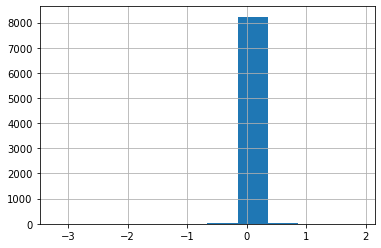

In [238]:
(ods.COMP_MILE_FY18_FINAL - ods.COMPOSITE_MILE).hist()

In [239]:
(ods.COMP_MILE_FY18_FINAL - ods.COMPOSITE_MILE).describe()

count    8281.000000
mean       -0.003801
std         0.087709
min        -3.220000
25%        -0.020000
50%         0.000000
75%         0.000000
max         1.890000
dtype: float64

In [240]:
(ods.COMP_MILE_FY18_FINAL - ods.COMPOSITE_MILE).max()

1.8900000000000006

In [241]:
ods[ods.COMP_MILE_FY18_FINAL - ods.COMPOSITE_MILE == (ods.COMP_MILE_FY18_FINAL - ods.COMPOSITE_MILE).max()]

,ORIGIN_MSTN_ID,ORIGIN_NAME,ORIGIN_X_COORD,ORIGIN_Y_COORD,DEST_MSTN_ID,DEST_NAME,DEST_X_COORD,DEST_Y_COORD,TRACK_MILE,COMPOSITE_MILE,CROW_FLIES_MILES_GIS,TRAVEL_TIME,TRACK_MILE_FY18_FINAL,COMP_MILE_FY18_FINAL,DIST_MI
1631,MSTN_057,LANDOVER,-76.891263,38.933496,MSTN_076,SOUTHERN AVENUE,-76.975209,38.840946,13.72,8.86,7.8255,36.0,13.68,10.75,7.825564
6395,MSTN_076,SOUTHERN AVENUE,-76.975209,38.840946,MSTN_057,LANDOVER,-76.891263,38.933496,13.72,8.86,7.8255,36.0,13.68,10.75,7.825564


Nearly 2 mile discrepancy, and again `COMP_MILE_FY18_FINAL` is correct.

In [242]:
(ods.COMP_MILE_FY18_FINAL - ods.COMPOSITE_MILE).min()

-3.219999999999999

In [243]:
ods[ods.COMP_MILE_FY18_FINAL - ods.COMPOSITE_MILE == (ods.COMP_MILE_FY18_FINAL - ods.COMPOSITE_MILE).min()]

,ORIGIN_MSTN_ID,ORIGIN_NAME,ORIGIN_X_COORD,ORIGIN_Y_COORD,DEST_MSTN_ID,DEST_NAME,DEST_X_COORD,DEST_Y_COORD,TRACK_MILE,COMPOSITE_MILE,CROW_FLIES_MILES_GIS,TRAVEL_TIME,TRACK_MILE_FY18_FINAL,COMP_MILE_FY18_FINAL,DIST_MI
2238,MSTN_069,VIENNA/FAIRFAX-GMU,-77.272457,38.877570,MSTN_038,VAN NESS-UDC,-77.062951,38.943203,18.61,18.61,12.165,45.0,18.61,15.39,12.165136
8645,MSTN_038,VAN NESS-UDC,-77.062951,38.943203,MSTN_069,VIENNA/FAIRFAX-GMU,-77.272457,38.877570,18.61,18.61,12.165,45.0,18.61,15.39,12.165136


Over 3 mile discrepancy. This time it seems by error `TRACK_MILE` and `COMPOSITE_MILE` are the same value. Again `COMP_MILE_FY18_FINAL` is correct.

Seems like `COMPOSITE_MILE` is unreliable, but `TRACK_MILE_FY18_FINAL` and `COMP_MILE_FY18_FINAL` are not available for newer stattions. I will do the following:
- Use `TRACK_MILE_FY18_FINAL` when available and `TRACK_MILE` otherwise to create `TRACK_MI`.
- Use `COMP_MILE_FY18_FINAL` when available and `COMPOSITE_MILE` otherwise to create `COMP_OLD_MI`.
- Create new field `COMP_MI` which is calculated as (`TRACK_MI` + `DIST_MI`)/2.

In [244]:
ods['TRACK_MI'] = ods.TRACK_MILE
ods.loc[ods.TRACK_MILE_FY18_FINAL > 0, 
        'TRACK_MI'] = ods.TRACK_MILE_FY18_FINAL

In [245]:
ods['COMP_OLD_MI'] = ods.COMPOSITE_MILE
ods.loc[ods.COMP_MILE_FY18_FINAL > 0, 
        'COMP_OLD_MI'] = ods.COMP_MILE_FY18_FINAL

In [246]:
ods['COMP_MI'] = (ods.DIST_MI + ods.TRACK_MI)/2.

Investigate any discrepancies between `COMP_OLD_MI` and `COMP_MI`.

In [247]:
(ods.COMP_MI - ods.COMP_OLD_MI).min()

-0.05

In [250]:
ods[ods.COMP_MI - ods.COMP_OLD_MI == (ods.COMP_MI - ods.COMP_OLD_MI).min()]

,ORIGIN_MSTN_ID,ORIGIN_NAME,ORIGIN_X_COORD,ORIGIN_Y_COORD,DEST_MSTN_ID,DEST_NAME,DEST_X_COORD,DEST_Y_COORD,TRACK_MILE,COMPOSITE_MILE,CROW_FLIES_MILES_GIS,TRAVEL_TIME,TRACK_MILE_FY18_FINAL,COMP_MILE_FY18_FINAL,DIST_MI,TRACK_MI,COMP_OLD_MI,COMP_MI
3068,MSTN_096,LOUDOUN GATEWAY,-77.460685,38.992040,MSTN_096,LOUDOUN GATEWAY,-77.460685,38.992040,0.0,0.05,NaN,NaN,NaN,NaN,0.0,0.0,0.05,0.0
3988,MSTN_092,RESTON TOWN CENTER,-77.360185,38.952768,MSTN_092,RESTON TOWN CENTER,-77.360185,38.952768,0.0,0.05,NaN,NaN,NaN,NaN,0.0,0.0,0.05,0.0
5856,MSTN_093,HERNDON,-77.385178,38.952821,MSTN_093,HERNDON,-77.385178,38.952821,0.0,0.05,NaN,NaN,NaN,NaN,0.0,0.0,0.05,0.0
5873,MSTN_094,INNOVATION CENTER,-77.415295,38.960758,MSTN_094,INNOVATION CENTER,-77.415295,38.960758,0.0,0.05,NaN,NaN,NaN,NaN,0.0,0.0,0.05,0.0
7307,MSTN_097,ASHBURN,-77.491537,39.005283,MSTN_097,ASHBURN,-77.491537,39.005283,0.0,0.05,NaN,NaN,NaN,NaN,0.0,0.0,0.05,0.0
7354,MSTN_095,DULLES AIRPORT,-77.448148,38.955784,MSTN_095,DULLES AIRPORT,-77.448148,38.955784,0.0,0.05,NaN,NaN,NaN,NaN,0.0,0.0,0.05,0.0


All are between stations and themselves on the Silver Line. Strange but nothing to worry about for our applications. `COMP_MI` is better to use here.

In [248]:
(ods.COMP_MI - ods.COMP_OLD_MI).max()

0.04148939442372779

In [249]:
ods[ods.COMP_MI - ods.COMP_OLD_MI == (ods.COMP_MI - ods.COMP_OLD_MI).max()]

,ORIGIN_MSTN_ID,ORIGIN_NAME,ORIGIN_X_COORD,ORIGIN_Y_COORD,DEST_MSTN_ID,DEST_NAME,DEST_X_COORD,DEST_Y_COORD,TRACK_MILE,COMPOSITE_MILE,CROW_FLIES_MILES_GIS,TRAVEL_TIME,TRACK_MILE_FY18_FINAL,COMP_MILE_FY18_FINAL,DIST_MI,TRACK_MI,COMP_OLD_MI,COMP_MI
3092,MSTN_017,FORT TOTTEN,-77.002294,38.951778,MSTN_094,INNOVATION CENTER,-77.415295,38.960758,29.77,25.97,NaN,NaN,NaN,NaN,22.252979,29.77,25.97,26.011489
7272,MSTN_094,INNOVATION CENTER,-77.415295,38.960758,MSTN_017,FORT TOTTEN,-77.002294,38.951778,29.77,25.97,NaN,NaN,NaN,NaN,22.252979,29.77,25.97,26.011489


The difference is not huge. The math seems to support the use of `COMP_MI` but I am curious about how WMATA's composite calculations came about.

In [251]:
ods

,ORIGIN_MSTN_ID,ORIGIN_NAME,ORIGIN_X_COORD,ORIGIN_Y_COORD,DEST_MSTN_ID,DEST_NAME,DEST_X_COORD,DEST_Y_COORD,TRACK_MILE,COMPOSITE_MILE,CROW_FLIES_MILES_GIS,TRAVEL_TIME,TRACK_MILE_FY18_FINAL,COMP_MILE_FY18_FINAL,DIST_MI,TRACK_MI,COMP_OLD_MI,COMP_MI
0,MSTN_042,ROCKVILLE,-77.146191,39.084264,MSTN_056,NEW CARROLLTON,-76.871868,38.948020,26.58,22.04,17.5009,65.0,26.59,22.04,17.500398,26.59,22.04,22.045199
1,MSTN_014,FEDERAL CENTER SW,-77.015935,38.885068,MSTN_012,FARRAGUT NORTH,-77.039666,38.903139,2.29,2.04,1.7866,14.0,2.29,2.04,1.786179,2.29,2.04,2.038090
2,MSTN_065,ARLINGTON CEMETERY,-77.063097,38.884581,MSTN_061,COURT HOUSE,-77.087141,38.890145,2.03,1.69,1.3499,10.0,2.03,1.69,1.351897,2.03,1.69,1.690949
3,MSTN_038,VAN NESS-UDC,-77.062951,38.943203,MSTN_059,WEST FALLS CHURCH-VT/UVA,-77.189219,38.900781,13.72,10.54,7.4066,38.0,13.71,10.56,7.406687,13.71,10.56,10.558343
4,MSTN_027,NAVY YARD-BALLPARK,-77.005875,38.876465,MSTN_048,FOREST GLEN,-77.042925,39.014938,12.35,11.06,9.7588,34.0,12.24,11.00,9.758329,12.24,11.00,10.999164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9404,MSTN_044,GLENMONT,-77.053546,39.061759,MSTN_093,HERNDON,-77.385178,38.952821,36.45,27.91,NaN,NaN,NaN,NaN,19.366396,36.45,27.91,27.908198
9405,MSTN_046,WHEATON,-77.050108,39.037535,MSTN_093,HERNDON,-77.385178,38.952821,34.68,26.82,NaN,NaN,NaN,NaN,18.960083,34.68,26.82,26.820041
9406,MSTN_046,WHEATON,-77.050108,39.037535,MSTN_096,LOUDOUN GATEWAY,-77.460685,38.992040,41.34,31.83,NaN,NaN,NaN,NaN,22.317355,41.34,31.83,31.828677
9407,MSTN_048,FOREST GLEN,-77.042925,39.014938,MSTN_095,DULLES AIRPORT,-77.448148,38.955784,36.88,29.53,NaN,NaN,NaN,NaN,22.194774,36.88,29.53,29.537387


In [252]:
ods = ods[["ORIGIN_MSTN_ID", 
           "ORIGIN_NAME", 
           "ORIGIN_X_COORD", 
           "ORIGIN_Y_COORD", 
           "DEST_MSTN_ID", 
           "DEST_NAME", 
           "DEST_X_COORD", 
           "DEST_Y_COORD",
           "TRACK_MI", 
           "DIST_MI",
           "COMP_OLD_MI", 
           "COMP_MI"]]

Save result

In [253]:
ods.to_csv("fare scenarios/rail_od_distances_cleaned.csv")

In [362]:
ods[(ods.ORIGIN_NAME == "GALLERY PLACE-CHINATOWN") & 
    (ods.DEST_NAME == "METRO CENTER")]

,ORIGIN_MSTN_ID,ORIGIN_NAME,ORIGIN_X_COORD,ORIGIN_Y_COORD,DEST_MSTN_ID,DEST_NAME,DEST_X_COORD,DEST_Y_COORD,TRACK_MI,DIST_MI,COMP_OLD_MI,COMP_MI
320,MSTN_019,GALLERY PLACE-CHINATOWN,-77.0228,38.898372,MSTN_024,METRO CENTER,-77.028086,38.898313,0.29,0.284972,0.29,0.287486


## Distances for zonal scenarios

The idea is to give each station a distance from the center of the system. 

We define the center of the system as the segment between Metro Center and Gallery Place-Chinatown, two stations that together serve all the lines. 

We define a station's set of distances from the center of the system as the set of distances between it and Metro Center or Gallery Place-Chinatown, whichever is closest by measure of track distance.

In [264]:
center_ods = ods[(ods.DEST_NAME == "METRO CENTER") | 
          (ods.DEST_NAME == "GALLERY PLACE-CHINATOWN")]

In [265]:
center_ods_groups = center_ods.groupby("ORIGIN_MSTN_ID")

In [266]:
stations = pd.DataFrame(columns = ["ORIGIN_MSTN_ID", 
                                   "ORIGIN_NAME", 
                                   "ORIGIN_X_COORD", 
                                   "ORIGIN_Y_COORD", 
                                   "DEST_MSTN_ID", 
                                   "DEST_NAME", 
                                   "DEST_X_COORD", 
                                   "DEST_Y_COORD",
                                   "TRACK_MI", 
                                   "DIST_MI",
                                   "COMP_OLD_MI", 
                                   "COMP_MI"])

In [267]:
for station, df in center_ods_groups:
    row = df[df.TRACK_MI == df.TRACK_MI.min()].iloc[0]
    stations = stations.append(row, ignore_index = True)

In [269]:
stations

,ORIGIN_MSTN_ID,ORIGIN_NAME,ORIGIN_X_COORD,ORIGIN_Y_COORD,DEST_MSTN_ID,DEST_NAME,DEST_X_COORD,DEST_Y_COORD,TRACK_MI,DIST_MI,COMP_OLD_MI,COMP_MI
0,MSTN_001,ANACOSTIA,-76.995557,38.863279,MSTN_019,GALLERY PLACE-CHINATOWN,-77.022800,38.898372,3.51,2.831512,3.16,3.170756
1,MSTN_002,ARCHIVES-NAVY MEMORIAL-PENN QUARTER,-77.021906,38.893217,MSTN_019,GALLERY PLACE-CHINATOWN,-77.022800,38.898372,0.36,0.358857,0.36,0.359429
2,MSTN_003,BENNING ROAD,-76.938617,38.891061,MSTN_019,GALLERY PLACE-CHINATOWN,-77.022800,38.898372,6.21,4.565961,5.36,5.387981
3,MSTN_004,BROOKLAND-CUA,-76.994544,38.933118,MSTN_019,GALLERY PLACE-CHINATOWN,-77.022800,38.898372,3.63,2.839606,3.24,3.234803
4,MSTN_005,CAPITOL SOUTH,-77.005213,38.885065,MSTN_019,GALLERY PLACE-CHINATOWN,-77.022800,38.898372,1.83,1.319620,1.56,1.574810
...,...,...,...,...,...,...,...,...,...,...,...,...
92,MSTN_093,HERNDON,-77.385178,38.952821,MSTN_024,METRO CENTER,-77.028086,38.898313,22.90,19.605262,21.26,21.252631
93,MSTN_094,INNOVATION CENTER,-77.415295,38.960758,MSTN_024,METRO CENTER,-77.028086,38.898313,24.58,21.303029,22.93,22.941514
94,MSTN_095,DULLES AIRPORT,-77.448148,38.955784,MSTN_024,METRO CENTER,-77.028086,38.898313,26.70,22.978453,24.83,24.839226
95,MSTN_096,LOUDOUN GATEWAY,-77.460685,38.992040,MSTN_024,METRO CENTER,-77.028086,38.898313,29.56,24.183765,26.87,26.871883


In [360]:
stations[stations.ORIGIN_NAME == "GALLERY PLACE-CHINATOWN"]

,ORIGIN_MSTN_ID,ORIGIN_NAME,ORIGIN_X_COORD,ORIGIN_Y_COORD,DEST_MSTN_ID,DEST_NAME,DEST_X_COORD,DEST_Y_COORD,TRACK_MI,DIST_MI,COMP_OLD_MI,COMP_MI,zone_a,zone_b,zone_c,zone_d,zone_e
18,MSTN_019,GALLERY PLACE-CHINATOWN,-77.0228,38.898372,MSTN_019,GALLERY PLACE-CHINATOWN,-77.0228,38.898372,0.1,0.0,0.05,0.05,1,1,1,1,1


## Create zones

### A. First pass: equal interval using crow-flies distance

In [270]:
stations[stations.DIST_MI == stations.DIST_MI.max()]

,ORIGIN_MSTN_ID,ORIGIN_NAME,ORIGIN_X_COORD,ORIGIN_Y_COORD,DEST_MSTN_ID,DEST_NAME,DEST_X_COORD,DEST_Y_COORD,TRACK_MI,DIST_MI,COMP_OLD_MI,COMP_MI
96,MSTN_097,ASHBURN,-77.491537,39.005283,MSTN_024,METRO CENTER,-77.028086,38.898313,31.5,26.030839,28.76,28.76542


In [271]:
max_dist = stations[stations.DIST_MI == stations.DIST_MI.max()].DIST_MI
max_dist = float(max_dist)

In [272]:
max_dist

26.03083917475229

In [273]:
n_zones = 5
interval = max_dist/n_zones
stations["zone_a"] = 0
for i in range(n_zones):
    zone = i+1
    stations.loc[stations.DIST_MI >= i*interval, 'zone_a'] = zone

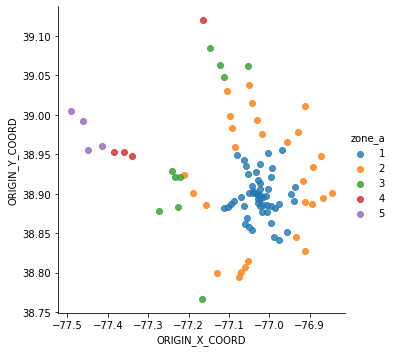

In [275]:
sns.lmplot(x = 'ORIGIN_X_COORD', 
           y = 'ORIGIN_Y_COORD', 
           data=stations, 
           hue='zone_a', 
           fit_reg=False)
plt.show()

In [434]:
def color(zone):
    return ['blue', 'orange', 'green', 'red', 'purple'][zone-1]

def add_points(mapobj, df, cat, popup_field_list):
    #Create a Folium feature group for this layer
    pt_lyr = folium.FeatureGroup(name = 'pt_lyr')
    for i, row in df.iterrows():
        #Append lat and long coordinates to "coords" list
        coords = (row.ORIGIN_Y_COORD, row.ORIGIN_X_COORD)
        #Create a string of HTML code used in the IFrame popup
        #Join together the fields in "popup_field_list" with a linebreak between them
        label = cat + ": " + str(row[cat]) + '<br>'
        label = label + '<br>'.join([field + ": " + str(row[field]) for field in popup_field_list])
        #Append an IFrame that uses the HTML string to the "popups" list
        iframe = folium.IFrame(label, width = 300, height = 100)
        popup = folium.Popup(iframe, max_width=2000)
        pt_lyr.add_child(folium.Circle(location = coords, 
                                       color=color(int(row[cat])), 
                                       popup = popup,
                                       radius=300, 
                                       fill=True,
                                       fillOpacity=1,
                                      ))
    
    #Add this point layer to the map object
    mapobj.add_child(pt_lyr)
    return mapobj

In [435]:
station_map = folium.Map([38.92, -77], zoom_start = 10, tiles='cartodbpositron')
station_map = add_points(station_map, 
                         stations, 
                         "zone_a", 
                         ['ORIGIN_MSTN_ID', 
                          'ORIGIN_NAME', 
                          'TRACK_MI', 
                          'COMP_MI',
                          'DIST_MI'])
station_map

Equal interval is not fit for this problem; Zone 1 is simply too large.

### B. Jenks natural breaks classification using crow-flies distance

In [436]:
breaks = jenkspy.jenks_breaks(stations['DIST_MI'], nb_class=5)
print(breaks)

[0.0, 3.84617450721275, 8.113615283407546, 13.251956269810611, 19.60526170869295, 26.03083917475229]


In [437]:
stations['zone_b'] = pd.cut(stations['DIST_MI'],
                            bins=breaks,
                            labels=[i+1 for i in range(5)], 
                            include_lowest=True)

In [438]:
station_map = folium.Map([38.92, -77], zoom_start = 10, tiles='cartodbpositron')
station_map = add_points(station_map, 
                         stations, 
                         "zone_b", 
                         ['ORIGIN_MSTN_ID', 
                          'ORIGIN_NAME', 
                          'TRACK_MI', 
                          'COMP_MI',
                          'DIST_MI'])
station_map

### C. Jenks based on track distance

In [439]:
breaks = jenkspy.jenks_breaks(stations['TRACK_MI'], nb_class=5)
print(breaks)

[0.1, 2.77, 6.21, 11.1, 17.91, 31.5]


In [440]:
stations['zone_c'] = pd.cut(stations['TRACK_MI'],
                            bins=breaks,
                            labels=[i+1 for i in range(5)], 
                            include_lowest=True)

In [441]:
station_map = folium.Map([38.92, -77], zoom_start = 10, tiles='cartodbpositron')
station_map = add_points(station_map, 
                         stations, 
                         "zone_c", 
                         ['ORIGIN_MSTN_ID', 
                          'ORIGIN_NAME', 
                          'TRACK_MI', 
                          'COMP_MI',
                          'DIST_MI'])
station_map

This is a great starting point! With some manual tweaking we can get a good result.

### D

In [442]:
jenkspy.jenks_breaks(stations['TRACK_MI'], nb_class=5)

[0.1, 2.77, 6.21, 11.1, 17.91, 31.5]

In [443]:
breaks = [0,
          2.4,
          7,
          10.5,
          14.75,
          40]

In [444]:
stations['zone_d'] = pd.cut(stations['TRACK_MI'],
                            bins=breaks,
                            labels=[i+1 for i in range(5)], 
                            include_lowest=True)

In [445]:
station_map = folium.Map([38.92, -77], zoom_start = 10, tiles='cartodbpositron')
station_map = add_points(station_map, 
                         stations, 
                         "zone_d", 
                         ['ORIGIN_MSTN_ID', 
                          'ORIGIN_NAME', 
                          'TRACK_MI', 
                          'COMP_MI',
                          'DIST_MI'])
station_map

### E

In [446]:
jenkspy.jenks_breaks(stations['TRACK_MI'], nb_class=5)

[0.1, 2.77, 6.21, 11.1, 17.91, 31.5]

In [447]:
breaks = [0,
          2.4,
          6.75,
          10.5,
          17.5,
          32]

In [448]:
stations['zone_e'] = pd.cut(stations['TRACK_MI'],
                            bins=breaks,
                            labels=[i+1 for i in range(5)], 
                            include_lowest=True)

In [449]:
station_map = folium.Map([38.92, -77], zoom_start = 10, tiles='cartodbpositron')
station_map = add_points(station_map, 
                         stations, 
                         "zone_e", 
                         ['ORIGIN_MSTN_ID', 
                          'ORIGIN_NAME', 
                          'TRACK_MI', 
                          'COMP_MI',
                          'DIST_MI'])
station_map

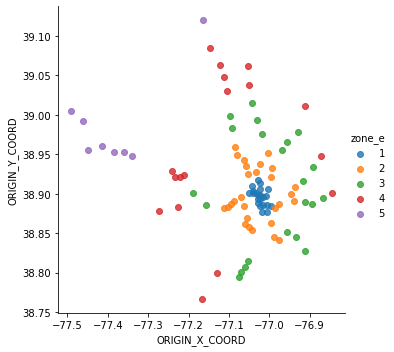

In [450]:
sns.lmplot(x = 'ORIGIN_X_COORD', 
           y = 'ORIGIN_Y_COORD', 
           data=stations, 
           hue='zone_e', 
           fit_reg=False)
plt.show()

In [451]:
stations.zone_e.value_counts()

2    28
1    22
3    22
4    17
5     8
Name: zone_e, dtype: int64

In [452]:
stations.to_csv("fare scenarios/stations_zoned.csv")